## Prediciting Diagnoses : Late Fusion 

Read in appropiate tables from MIMIC-III
* Admissions
* Patients
* Codes 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_admissions = pd.read_csv('mimic_bow/ADMISSIONS.csv')
df_patients = pd.read_csv('PATIENTS.csv')
df_codes = pd.read_csv('DIAGNOSES_ICD.csv')


In [2]:
merged_data = pd.merge(df_admissions, df_patients, on='SUBJECT_ID')
patients_subset = merged_data['SUBJECT_ID'].unique()[:30000]
patients_df_25 = merged_data[df_admissions['SUBJECT_ID'].isin(patients_subset)]
## remove newborns
patients_df_25 = patients_df_25.loc[patients_df_25.ADMISSION_TYPE != 'NEWBORN'].copy()


## Structured Dataset Preprocessing

In [3]:
# Diagnosis is target or independent variable
from datetime import datetime

demographics_df = patients_df_25[['DIAGNOSIS','GENDER','DOB','ETHNICITY','INSURANCE','ADMITTIME','SUBJECT_ID']]
demographics_df['DOB'] = pd.to_datetime(demographics_df['DOB']).dt.year
demographics_df['ADMITTIME'] = pd.to_datetime(demographics_df['ADMITTIME']).dt.year
demographics_df['AGE'] = demographics_df['ADMITTIME'] - demographics_df['DOB']
demographics_df = demographics_df[(demographics_df['AGE'] >= 20) & (demographics_df['AGE'] <= 80 )] # drop rows less than 20 and greater than 80, due to classified admittime and dob
demographics_df

C:\Users\Brendan Mckeown\AppData\Local\Temp\ipykernel_12352\850842306.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_df['DOB'] = pd.to_datetime(demographics_df['DOB']).dt.year
C:\Users\Brendan Mckeown\AppData\Local\Temp\ipykernel_12352\850842306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographics_df['ADMITTIME'] = pd.to_datetime(demographics_df['ADMITTIME']).dt.year
C:\Users\Brendan Mckeown\AppData\Local\Temp\ipykernel_12352\850842306.py:7: SettingWithCopyWarning: 
A value is 

,DIAGNOSIS,GENDER,DOB,ETHNICITY,INSURANCE,ADMITTIME,SUBJECT_ID,AGE
0,BENZODIAZEPINE OVERDOSE,F,2131,WHITE,Private,2196,22,65
1,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,2082,WHITE,Medicare,2153,23,71
2,BRAIN MASS,M,2082,WHITE,Medicare,2157,23,75
3,INTERIOR MYOCARDIAL INFARCTION,M,2100,WHITE,Private,2139,24,39
4,ACUTE CORONARY SYNDROME,M,2101,WHITE,Private,2160,25,59
...,...,...,...,...,...,...,...,...
38991,ABSCESS,M,2125,MULTI RACE ETHNICITY,Medicaid,2180,30396,55
39955,CONGESTIVE HEART FAILURE,F,2112,WHITE,Medicaid,2149,32434,37
39956,FEVER,F,2122,WHITE,Medicare,2192,32435,70
40052,V-TACH/CARDIOVERSION,M,2064,WHITE,Private,2130,29946,66


Read in the CHARTEVENTS table from MIMIC-III for continous values i.e blood pressure and heart rate

In [4]:
df_chartEvents = pd.read_csv('CHARTEVENTS.csv')


In [5]:
# only use SUBJECT_IDS that are in the above demographics datasets
unique_ids = df_chartEvents.SUBJECT_ID.unique()
demographics_df = demographics_df[(demographics_df['SUBJECT_ID'].isin(unique_ids))]
merged_data_cont = pd.merge(df_chartEvents, patients_df_25, on='SUBJECT_ID')

In [6]:
# only take the values that are heart rate (bpm) and blood pressure (mmHg)
cont_df_25 = merged_data_cont[(merged_data_cont['VALUEUOM'] == 'bpm') | (merged_data_cont['VALUEUOM'] == 'mmHg' )]
cont_df_25 = cont_df_25[['SUBJECT_ID','VALUENUM', 'VALUEUOM','DIAGNOSIS']]
cont_df_25

,SUBJECT_ID,VALUENUM,VALUEUOM,DIAGNOSIS
27,36,58.0,mmHg,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
28,36,58.0,mmHg,CHEST PAIN/SHORTNESS OF BREATH
29,36,58.0,mmHg,VENTRAL HERNIA/SDA
30,36,60.0,mmHg,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
31,36,60.0,mmHg,CHEST PAIN/SHORTNESS OF BREATH
...,...,...,...,...
20032234,46340,69.0,mmHg,ALTERED MENTAL STATUS
20032238,46340,67.0,bpm,ALTERED MENTAL STATUS
20032239,46340,99.0,mmHg,ALTERED MENTAL STATUS
20032240,46340,60.0,mmHg,ALTERED MENTAL STATUS


## Filter the diagnoses to get the top 10 most frequent

In [7]:
cont25_df_top10 = cont_df_25['DIAGNOSIS'].value_counts().nlargest(10)
cont25_10_codes_df1 = cont25_df_top10.reset_index()
cont25_10_codes_df1.columns = ['DIAGNOSIS', 'Frequency']
top10_cont = cont25_10_codes_df1['DIAGNOSIS']
cont_df_25 = cont_df_25.loc[cont_df_25['DIAGNOSIS'].isin(top10_cont)]

# Normalize blood pressure and heart rate to z-score values and get max,min values for each patient

In [8]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

scaler = StandardScaler()
# Define a function to normalize the data using Z-score standardization
blood_pressure_df = cont_df_25[cont_df_25['VALUEUOM'] == 'mmHg']
heart_rate_df = cont_df_25[cont_df_25['VALUEUOM'] == 'bpm']
blood_pressure_df_maxmin = blood_pressure_df.groupby('SUBJECT_ID')['VALUENUM'].agg(['max','min']).reset_index()
heart_rate_df_maxmin = heart_rate_df.groupby('SUBJECT_ID')['VALUENUM'].agg(['max','min']).reset_index()
zscore_df_bp_col = zscore(blood_pressure_df['VALUENUM'])
blood_pressure_df['Z_Score_BP'] = zscore_df_bp_col

zscore_df_hr_col = zscore(heart_rate_df['VALUENUM'])
heart_rate_df['Z_Score_HR'] = zscore_df_hr_col

blood_pressure_df = blood_pressure_df.groupby('SUBJECT_ID').mean()
heart_rate_df = heart_rate_df.groupby('SUBJECT_ID').mean()
new_df =  cont_df_25.merge(blood_pressure_df, on='SUBJECT_ID',how='left')
new_df = new_df.merge(heart_rate_df,on='SUBJECT_ID',how='left')
new_df = new_df.merge(blood_pressure_df_maxmin,on='SUBJECT_ID',how='left')
new_df = new_df.merge(heart_rate_df_maxmin,on='SUBJECT_ID',how='left')
new_df =new_df.drop_duplicates(subset='SUBJECT_ID')[['SUBJECT_ID', 'Z_Score_BP', 'Z_Score_HR', 'max_x', 'min_x', 'max_y', 'min_y']].reset_index(drop=True)


C:\Users\Brendan Mckeown\AppData\Local\Temp\ipykernel_12352\153954467.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_pressure_df['Z_Score_BP'] = zscore_df_bp_col
C:\Users\Brendan Mckeown\AppData\Local\Temp\ipykernel_12352\153954467.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_rate_df['Z_Score_HR'] = zscore_df_hr_col


As most of the blood pressure z-scores are quite close together, we will filter the ones that are outside one standard deviation of the mean and clamp them to ten standard deviations outside the mean to show that these are abnormal values.

C:\Users\Brendan Mckeown\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


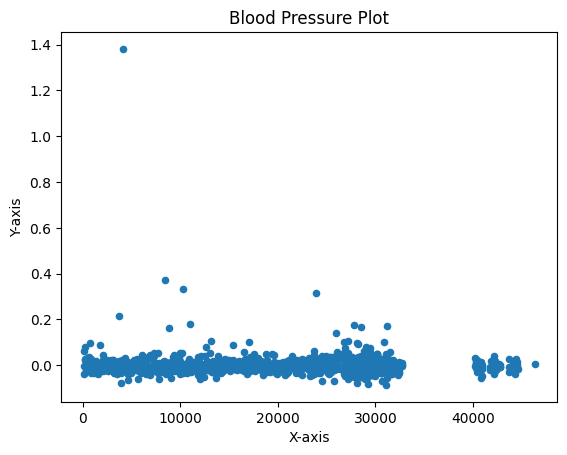

In [9]:
import matplotlib.pyplot as plt

new_df.plot.scatter(x='SUBJECT_ID', y='Z_Score_BP')

# Set plot labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Blood Pressure Plot')

# Show the plot
plt.show()


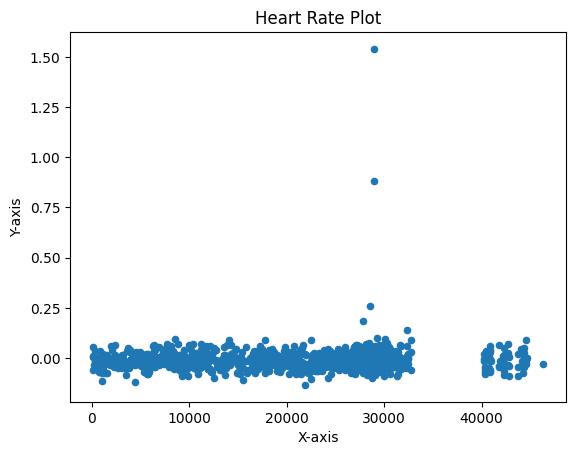

In [10]:
new_df.plot.scatter(x='SUBJECT_ID', y='Z_Score_HR')

# Set plot labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heart Rate Plot')

# Show the plot
plt.show()

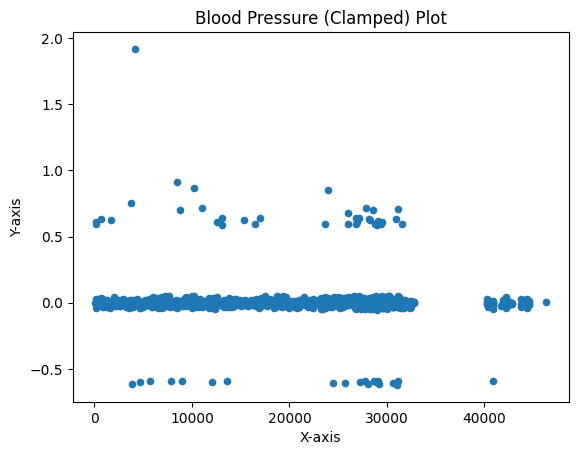

In [11]:
# Clamp outliers to 10 standard deviations 
# Calculate the mean and standard deviation of the column
mean_val_bp = new_df['Z_Score_BP'].mean()
std_val_bp = new_df['Z_Score_BP'].std()
mean_val_hr = new_df['Z_Score_HR'].mean()
std_val_hr = new_df['Z_Score_HR'].std()
# Calculate the threshold value as 10 standard deviations from the mean
threshold_bp = mean_val_bp + (10 * std_val_bp)
threshold_hr = mean_val_hr + (10 * std_val_hr)

new_df.loc[new_df['Z_Score_BP'] >= mean_val_bp + std_val_bp, 'Z_Score_BP'] += threshold_bp
new_df.loc[new_df['Z_Score_HR'] >= mean_val_hr + std_val_hr, 'Z_Score_HR'] += threshold_hr

new_df.loc[new_df['Z_Score_BP'] <= mean_val_bp - std_val_bp, 'Z_Score_BP'] -= threshold_bp
new_df.loc[new_df['Z_Score_HR'] <= mean_val_hr - std_val_hr, 'Z_Score_HR'] -= threshold_hr

new_df.plot.scatter(x='SUBJECT_ID', y='Z_Score_BP')

# Set plot labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Blood Pressure (Clamped) Plot')

# Show the plot
plt.show()

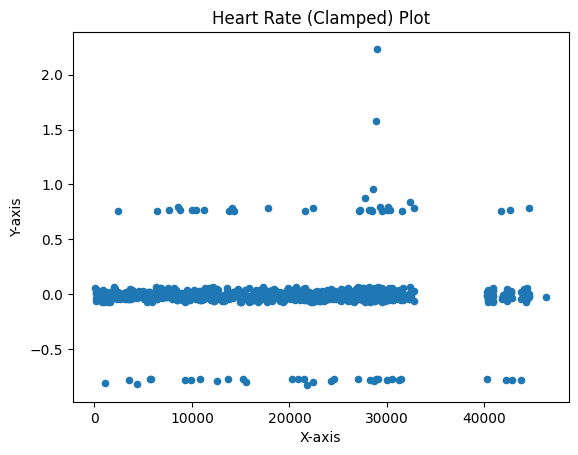

In [12]:
new_df.plot.scatter(x='SUBJECT_ID', y='Z_Score_HR')

# Set plot labels and title (optional)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heart Rate (Clamped) Plot')

# Show the plot
plt.show()

In [13]:
# Add label encoders
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()
le4 = preprocessing.LabelEncoder()

# Merge continous values to structured dataframe 
demographics_df =  demographics_df.merge(new_df, on='SUBJECT_ID',how='inner')
unique_ids_proper = demographics_df.SUBJECT_ID.unique()


In [14]:
demographics_df = demographics_df[['SUBJECT_ID','DIAGNOSIS','GENDER', 'DOB', 'ETHNICITY','AGE', 'Z_Score_BP','Z_Score_HR','max_x','min_x','max_y','min_y']]
demographics_df = demographics_df.dropna()
demographics_df_top10 = demographics_df['DIAGNOSIS'].value_counts().nlargest(10)
top_10_codes_df1 = demographics_df_top10.reset_index()
top_10_codes_df1.columns = ['DIAGNOSIS', 'Frequency']
top10 = top_10_codes_df1['DIAGNOSIS']
demographics_df1 = demographics_df.loc[demographics_df['DIAGNOSIS'].isin(top10)]
unique_ids_proper1 = demographics_df1.SUBJECT_ID.unique()

## Obtain ICD-9 Codes Associated with each Subject_ID

In [15]:
demographic_codes = demographics_df1.merge(df_codes, on='SUBJECT_ID', how='inner')
demographic_codes

,SUBJECT_ID,DIAGNOSIS,GENDER,DOB,ETHNICITY,AGE,Z_Score_BP,Z_Score_HR,max_x,min_x,max_y,min_y,ROW_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4245,101651,1.0,5070
1,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4246,101651,2.0,42822
2,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4247,101651,3.0,3453
3,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4248,101651,4.0,2760
4,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4249,101651,5.0,1550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110690,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407261,111666,5.0,25060
110691,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407262,111666,6.0,3572
110692,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407263,111666,7.0,V5867
110693,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407264,111666,8.0,25040


# Add if the patient was/is a current or previous smoker

In [16]:
current_tobacco = '3051' 
previous_tobacco = 'V1582'

rows_with_current_tobacco = demographic_codes[demographic_codes['ICD9_CODE'] == current_tobacco]
rows_with_previous_tobacco = demographic_codes[demographic_codes['ICD9_CODE'] == previous_tobacco]
current_tobacco_subject = rows_with_current_tobacco.SUBJECT_ID.unique()
past_tobacco_subject = rows_with_previous_tobacco.SUBJECT_ID.unique()

Cut the ICD-9 Codes to three as this allows for greater generilization of diagnoses

In [17]:
# Only take first three codes
def preprocess_code(df):
    df['ICD9_CODE'] = df['ICD9_CODE'].str[:3]
    return df
preprocess_code(demographic_codes)

,SUBJECT_ID,DIAGNOSIS,GENDER,DOB,ETHNICITY,AGE,Z_Score_BP,Z_Score_HR,max_x,min_x,max_y,min_y,ROW_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4245,101651,1.0,507
1,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4246,101651,2.0,428
2,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4247,101651,3.0,345
3,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4248,101651,4.0,276
4,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4249,101651,5.0,155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110690,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407261,111666,5.0,250
110691,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407262,111666,6.0,357
110692,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407263,111666,7.0,V58
110693,46340,ALTERED MENTAL STATUS,M,2052,WHITE,51,0.005706,-0.029533,160.0,49.0,120.0,15.0,407264,111666,8.0,250


# Obtain the most important diagnoses by using the first diagnoses given to patient

In [18]:
# Only take most important code first SEQ_NUM = 1
demographic_codes = demographic_codes[(demographic_codes['SEQ_NUM'] == 1)]
demographic_codes

,SUBJECT_ID,DIAGNOSIS,GENDER,DOB,ETHNICITY,AGE,Z_Score_BP,Z_Score_HR,max_x,min_x,max_y,min_y,ROW_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4245,101651,1.0,507
17,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4262,117876,1.0,486
39,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4284,122609,1.0,276
63,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4308,145674,1.0,345
82,357,SEPSIS,M,2135,WHITE,63,-0.010766,-0.018861,160.0,30.0,120.0,22.0,4327,174486,1.0,571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110640,32434,CONGESTIVE HEART FAILURE,F,2112,WHITE,37,0.000043,0.019749,200.0,46.0,120.0,50.0,374091,146004,1.0,410
110648,32434,CONGESTIVE HEART FAILURE,F,2112,WHITE,37,0.000043,0.019749,200.0,46.0,120.0,50.0,374099,153109,1.0,584
110661,32434,CONGESTIVE HEART FAILURE,F,2112,WHITE,37,0.000043,0.019749,200.0,46.0,120.0,50.0,374112,197544,1.0,428
110672,32435,FEVER,F,2122,WHITE,70,-0.007207,-0.006817,175.0,-1.0,140.0,50.0,374123,173167,1.0,518


In [19]:
# remove codes that are not numbers
demographic_codes['ICD9_CODE'] = pd.to_numeric(demographic_codes['ICD9_CODE'], errors='coerce')
demographic_codes = demographic_codes.dropna(subset=['ICD9_CODE'])

C:\Users\Brendan Mckeown\AppData\Local\Temp\ipykernel_12352\4143627041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demographic_codes['ICD9_CODE'] = pd.to_numeric(demographic_codes['ICD9_CODE'], errors='coerce')


In [20]:
demographics_codes_top10 = demographic_codes['ICD9_CODE'].value_counts()
demographics_codes_top10

250.0    1800
38.0      608
428.0     568
403.0     411
996.0     391
         ... 
692.0       1
596.0       1
156.0       1
199.0       1
293.0       1
Name: ICD9_CODE, Length: 257, dtype: int64

# Get the latest vist for each patient 
Check later - B

In [21]:
demographic_codes = demographic_codes.loc[demographic_codes.groupby('SUBJECT_ID')['HADM_ID'].idxmax()]

# If the patient is a current or previous tobacco user, a 1 will appear in the column 

In [22]:
def check_past_tobacco(subject_id):
    return 1 if subject_id in past_tobacco_subject else 0

def check_current_tobacco(subject_id):
    return 1 if subject_id in current_tobacco_subject else 0

# Apply the function to create the new column
demographic_codes['past_tobacco'] = demographic_codes['SUBJECT_ID'].apply(check_past_tobacco)
demographic_codes['current_tobacco'] = demographic_codes['SUBJECT_ID'].apply(check_current_tobacco)


# Encode labels for diagnois, gender and ethncity and spilt into training and testing subsets

In [23]:
demographics_df1_holder = demographic_codes[['DIAGNOSIS','GENDER', 'DOB', 'ETHNICITY','AGE', 'ICD9_CODE', 'Z_Score_BP','Z_Score_HR','max_x','min_x','max_y','min_y', 'past_tobacco', 'current_tobacco']]
demographics_array1 = demographics_df1_holder.to_numpy()
diagnosis_array = demographics_array1[:,0]
gender_array = demographics_array1[:,1]
ethnicity_array = demographics_array1[:,3]

demographics_array1[:,0] = le1.fit_transform(diagnosis_array)
demographics_array1[:,1] = le2.fit_transform(gender_array)
demographics_array1[:,3] = le3.fit_transform(ethnicity_array)

training_cont = demographics_array1[:, 1:]
testing_cont = demographics_array1[:,0]

# Top 10 Diagnosis

In [24]:
top_10_codes_df1

,DIAGNOSIS,Frequency
0,PNEUMONIA,227
1,SEPSIS,167
2,CONGESTIVE HEART FAILURE,163
3,DIABETIC KETOACIDOSIS,148
4,ALTERED MENTAL STATUS,94
5,FEVER,87
6,CHEST PAIN,84
7,ABDOMINAL PAIN,84
8,HYPOTENSION,71
9,LOWER GI BLEED,55


In [25]:
from tensorflow import keras
from keras import layers
from keras.layers import Input, Concatenate, Dense
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# X_train, X_test, y_train, y_test = train_test_split(training_cont, testing_cont, test_size=0.3, random_state=422)
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)
# y_train = y_train.astype(np.float64)
# y_test = y_test.astype(np.float64)


## Unstructured Dataset Preprocesing 
Read in appropiate tables from MIMIC-III
* Notevents

In [26]:
df_notes = pd.read_csv("mimic_bow/NOTEEVENTS.csv")


C:\Users\Brendan Mckeown\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ') # remove nan values
    df.TEXT = df.TEXT.str.replace('\n',' ') # remove new lines breaks
    df.TEXT = df.TEXT.str.replace('\r',' ') # remove line breaks
    df.TEXT = df.TEXT.str.replace('\d+', ' ', regex=True) # remove numbers
    return df
df_notes = preprocess_text(df_notes)

Only use discharge summaries for notes as these contain the most feature rich data for each patient (source?)

In [28]:
values = ['Discharge summary']
df_notes_filtered = df_notes.loc[df_notes['CATEGORY'].isin(values)]

In [29]:
merged_df = df_notes_filtered.merge(demographics_df1[['SUBJECT_ID', 'DIAGNOSIS']], on='SUBJECT_ID', how='inner')

In [30]:
merged_df = merged_df[['SUBJECT_ID','HADM_ID', 'DIAGNOSIS', 'TEXT']]
merged_df

,SUBJECT_ID,HADM_ID,DIAGNOSIS,TEXT
0,11018,104650.0,PNEUMONIA,Admission Date: [** - - **] Disc...
1,11018,104650.0,ABDOMINAL PAIN,Admission Date: [** - - **] Disc...
2,11018,186291.0,PNEUMONIA,Admission Date: [** - - **] Disc...
3,11018,186291.0,ABDOMINAL PAIN,Admission Date: [** - - **] Disc...
4,11018,180836.0,PNEUMONIA,Admission Date: [** - - **] Disc...
...,...,...,...,...
7936,6378,199603.0,PNEUMONIA,Admission Date: [** - - **] Disc...
7937,6378,199603.0,CONGESTIVE HEART FAILURE,Admission Date: [** - - **] Disc...
7938,6378,199603.0,PNEUMONIA,Admission Date: [** - - **] Disc...
7939,29305,191380.0,ABDOMINAL PAIN,Admission Date: [** - - **] Disc...


# Only use patient that have discharge summaries in the noteevents table

In [31]:
merged_df = merged_df.loc[merged_df['SUBJECT_ID'].isin(unique_ids_proper1)]# in chart events

In [32]:
# Get latest discharge summary per vist
merged_df = (merged_df.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()

Import libaries for tf-idf and word tokenization

In [33]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [34]:
# Text preprocessing: lowercase, remove non-alphanumeric characters, and tokenize
def preprocess_text1(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    return ' '.join(words)

In [35]:

merged_df['cleaned_text'] = merged_df['TEXT'].apply(preprocess_text1)


Remove unnecessary stop-words

In [36]:
from nltk.corpus import stopwords

stop_words1 = list(stopwords.words('english'))

In [37]:
# Also remove words that are frequently used in the discharge summaries that are irrelevant
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also', 'admission', 'date', 'discharge', 'birth', 'sex', 'service', 
                'known', 'firstname', 'lastname','medicine', 'allergies'] 

stop_words = my_stop_words + stop_words1 
merged_df['cleaned_text'] = merged_df['cleaned_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [38]:
top_10_codes = merged_df['DIAGNOSIS'].value_counts().nlargest(10)
top_10_codes_df = top_10_codes.reset_index()
top_10_codes_df.columns = ['DIAGNOSIS', 'Frequency']
top10 = top_10_codes_df['DIAGNOSIS']
top10

0                   PNEUMONIA
1    CONGESTIVE HEART FAILURE
2                      SEPSIS
3       ALTERED MENTAL STATUS
4              ABDOMINAL PAIN
5       DIABETIC KETOACIDOSIS
6                  CHEST PAIN
7                 HYPOTENSION
8                       FEVER
9              LOWER GI BLEED
Name: DIAGNOSIS, dtype: object

Only use top 10 most frequent diagnoses

In [39]:
top_10_codes = merged_df['DIAGNOSIS'].value_counts().nlargest(10)
top_10_codes_df = top_10_codes.reset_index()
top_10_codes_df.columns = ['DIAGNOSIS', 'Frequency']
top10 = top_10_codes_df['DIAGNOSIS']
merged_df1 = merged_df.loc[merged_df['DIAGNOSIS'].isin(top10)]

# TF-IDF Vectorization of Text

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_all = tfidf_vectorizer.fit_transform(merged_df1['cleaned_text'])

## Fusion of Structured and Unstructured Datasets - Early Fusion

Merge strucutred and unstructured datasets

In [41]:
all_df = demographic_codes.merge(merged_df, on='SUBJECT_ID', how='inner')

# Prep strucutred

In [42]:
structured_df = all_df[['SUBJECT_ID','DIAGNOSIS_x','GENDER', 'DOB', 'ETHNICITY','AGE', 'ICD9_CODE', 'Z_Score_BP','Z_Score_HR','max_x','min_x','max_y','min_y', 'past_tobacco', 'current_tobacco']]
structured_df = structured_df.dropna()
structured_df_df_top10 = structured_df['DIAGNOSIS_x'].value_counts().nlargest(10)
top_10_codes_strucutred = structured_df_df_top10.reset_index()
top_10_codes_strucutred.columns = ['DIAGNOSIS_x', 'Frequency']
top10_strucutred = top_10_codes_strucutred['DIAGNOSIS_x']

structured_df = structured_df.loc[structured_df['DIAGNOSIS_x'].isin(top10_strucutred)]
unique_ids_strut = structured_df.SUBJECT_ID.unique()
structured_df1 = structured_df[['DIAGNOSIS_x','GENDER', 'DOB', 'ETHNICITY','AGE', 'ICD9_CODE', 'Z_Score_BP','Z_Score_HR','max_x','min_x','max_y','min_y', 'past_tobacco', 'current_tobacco']]
strucutred_array1 = structured_df1.to_numpy()
diagnosis_array_strut = strucutred_array1[:,0]
gender_array_strut = strucutred_array1[:,1]
ethnicity_array_strut = strucutred_array1[:,3]

strucutred_array1[:,0] = le1.fit_transform(diagnosis_array_strut)
strucutred_array1[:,1] = le2.fit_transform(gender_array_strut)
strucutred_array1[:,3] = le3.fit_transform(ethnicity_array_strut)

training_cont_strut = strucutred_array1[:, 1:]
testing_cont_strut = strucutred_array1[:,0]

X_train_sturt, X_test_strut, y_train_strut, y_test_strut = train_test_split(training_cont_strut, testing_cont_strut, test_size=0.3, random_state=421)

X_train_sturt = X_train_sturt.astype(np.float64)
X_test_strut = X_test_strut.astype(np.float64)
y_train_strut = y_train_strut.astype(np.float64)
y_test_strut = y_test_strut.astype(np.float64)

## Unstructured Prep

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
all_df_unstrut = all_df[['SUBJECT_ID','HADM_ID_x', 'DIAGNOSIS_x', 'TEXT', 'cleaned_text']]
all_df_unstrut = all_df_unstrut.loc[all_df_unstrut['SUBJECT_ID'].isin(unique_ids_strut)]# in chart events

top_10_codes_unstrut = all_df_unstrut['DIAGNOSIS_x'].value_counts().nlargest(10)
top_10_codes_df_unstrut = top_10_codes_unstrut.reset_index()
top_10_codes_df_unstrut.columns = ['DIAGNOSIS_x', 'Frequency']
top10_unstrut = top_10_codes_df_unstrut['DIAGNOSIS_x']
all_df_unstrut = all_df_unstrut.loc[all_df_unstrut['DIAGNOSIS_x'].isin(top10_unstrut)]
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix_unstrut = tfidf_vectorizer.fit_transform(all_df_unstrut['cleaned_text'])

X_unstrut = tfidf_matrix_unstrut
y_unstrut = le1.fit_transform(all_df_unstrut['DIAGNOSIS_x'])
# Set k to the number of top features you want to keep
selector = SelectKBest(score_func=chi2, k=5000) 
X_unstrut = selector.fit_transform(X_unstrut, y_unstrut)
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X_unstrut, y_unstrut, test_size=0.3, random_state=421)
X_train_un = X_train_un.toarray()
X_test_un = X_test_un.toarray()

 
## Classifiers
 * Multinomial Logistic Regression
 * Decison Tree Classifier
 * K-Nearest Neighbour Classifier
 * Random Forest Classifier
 * Gradient Boosting Classifier
 * Support Vector Machine 

Train and test datasets are equal

In [44]:
result1 = np.array_equal(y_test_un, y_test_strut)
result2 = np.array_equal(y_train_strut, y_train_un)
print(result1)
print(result2)

True
True


# Late Fusion Model

In [45]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import display
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



In [46]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.naive_bayes import ComplementNB


# Initialize multiple classification models
models_un = [
    ('Support Vector Machine',make_pipeline(StandardScaler(), SVC(kernel='linear', decision_function_shape='ovo'))),
    ('Random Forest', RandomForestClassifier(n_estimators=2000,  bootstrap=False)),
    ('K Nearest Neighbour', KNeighborsClassifier(n_neighbors = 2, weights = 'distance', metric='minkowski')),
    ('Logistic Regression', LogisticRegression(multi_class='multinomial',  penalty="none",solver='saga', max_iter=200)),
    ('Decison Tree', DecisionTreeClassifier(criterion='entropy')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators = 75)), 
]

# Initialize lists to store model names and accuracy values
model_names_un = []
accuracy_values_un = []

# Iterate through models, train, predict, and calculate accuracy
for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    y_pred_un = model.predict(X_test_un)
    accuracy_un = accuracy_score(y_test_un, y_pred_un)
    
    model_names_un.append(name)
    accuracy_values_un.append(accuracy_un)
print(accuracy_values_un)

C:\Users\Brendan Mckeown\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[0.7089820359281437, 0.5317365269461077, 0.5700598802395209, 0.6383233532934132, 0.3149700598802395, 0.5508982035928144]


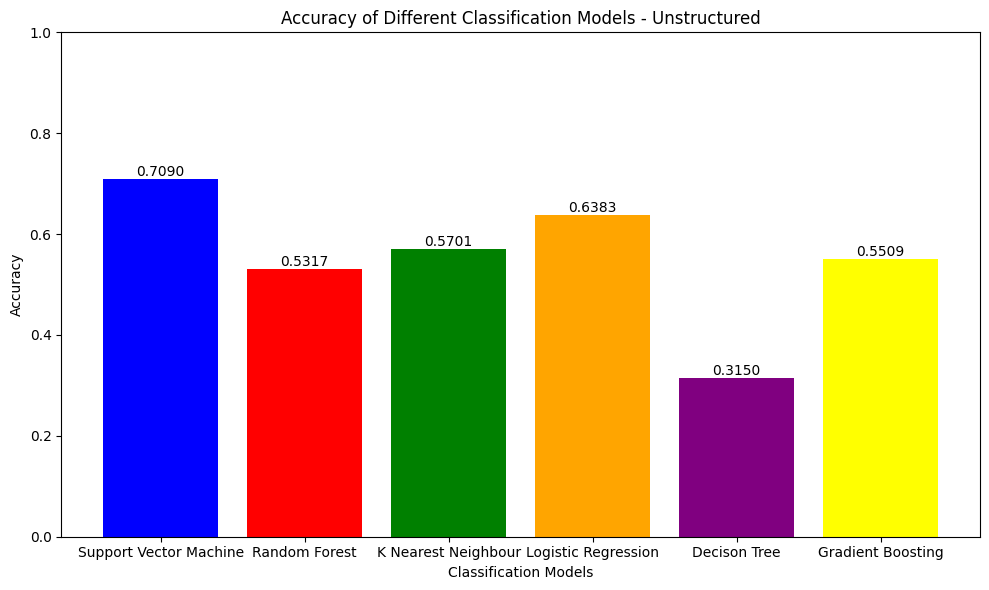

In [47]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
plt.bar(model_names_un, accuracy_values_un, color=colors)
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classification Models - Unstructured')

for i, value in enumerate(accuracy_values_un):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [48]:
# Initialize multiple classification models
models_strut = [
    ('Support Vector Machine',make_pipeline(StandardScaler(), SVC(kernel='rbf', decision_function_shape='ovo'))),
    ('Random Forest', RandomForestClassifier(n_estimators=2000,  bootstrap=False)),
    ('K Nearest Neighbour', KNeighborsClassifier(n_neighbors = 30, weights = 'distance', metric='minkowski')),
    ('Logistic Regression', LogisticRegression(multi_class='multinomial', penalty="l2", solver='newton-cg', max_iter=200)),
    ('Decison Tree', DecisionTreeClassifier(criterion='entropy')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators =250)), 
]

# Initialize lists to store model names and accuracy values
model_names_strut = []
accuracy_values_strut = []

# Iterate through models, train, predict, and calculate accuracy
for name_strut, model_strut in models_strut:
    model_strut.fit(X_train_sturt, y_train_strut)
    y_pred_strut = model_strut.predict(X_test_strut)
    accuracy_strut = accuracy_score(y_test_strut, y_pred_strut)
    
    model_names_strut.append(name_strut)
    accuracy_values_strut.append(accuracy_strut)
print(accuracy_values_strut)

C:\Users\Brendan Mckeown\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


[0.4994011976047904, 0.9437125748502994, 0.9413173652694611, 0.3413173652694611, 0.9401197604790419, 0.9532934131736527]


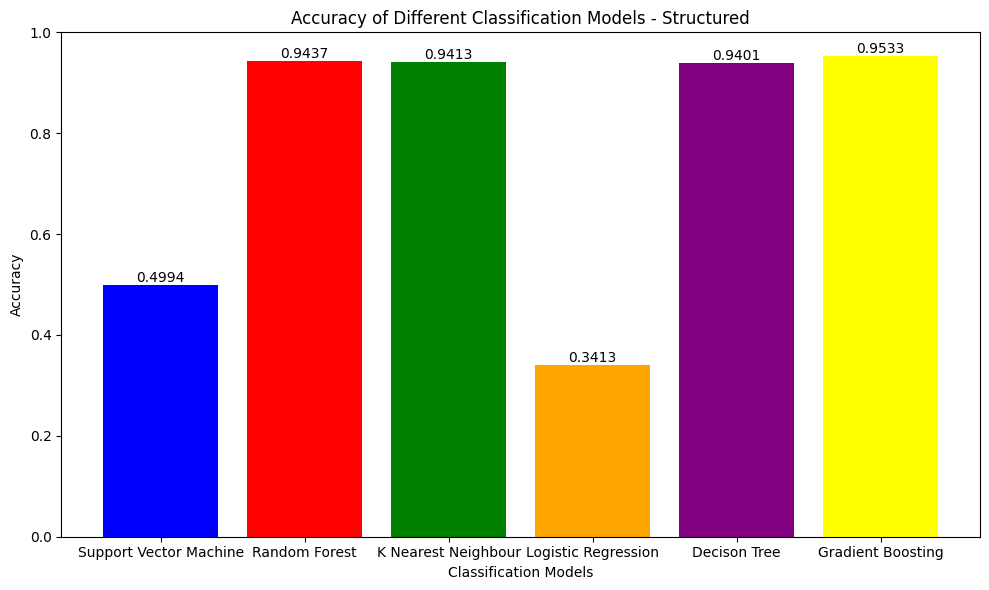

In [49]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta']
plt.bar(model_names_strut, accuracy_values_strut, color=colors)
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classification Models - Structured')

for i, value in enumerate(accuracy_values_strut):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Mean accuracy from both classifiers

In [50]:


mean_accuracy_late = ( (max(accuracy_values_un) + max(accuracy_values_strut)) / 2)

print(mean_accuracy_late)

0.8311377245508982
